In [1]:
import csv
import matplotlib.pyplot as plt
from snsphd import viz
import numpy as np
from snsphd.hist import SplineTool
from snsphd.help import prinfo
from snsphd.layout import bisect, margin

from scipy.signal import find_peaks


from typing import Tuple

Colors, swatches = viz.phd_style(jupyterStyle=True, svg_mode=True)
from dataclasses import dataclass

from scipy.optimize import leastsq, curve_fit

import json

from utils import load_spectrum_file, gaussian, frequency_and_bandwidth

from spdc_functions import (
    ExtraordinaryIndex,
    ExtraordinaryIndex1Percent,
    OrdinaryIndex,
    Mgo_doped_Linb03_calculate_indexes,
    Linb03_calculate_indexes,
    DetectorParams,
    SpdcParams,
    JointSpectrumParams,
    refractive_index_ppln,
    gaussian2D,
    detector_profile,
    pump_envelope,
    phase_mismatch,
    # sinc2,
    sinc2_monochromatic,
    spdc_profile,
    wl_pump_envelope,
    joint_spectrum,
    joint_spectrum_no_detector,
    wrapper_joint_spectrum,
    GaussianFilterParams,
    single_filter,
    lmfit_wrapper_join_spectrum,
    lmfit_wrapper_join_spectrum_filter_integrate,
    Dwdm,
    dwdm2D,
    create_signal_idler_arrays
)

from lmfit import Model
from matplotlib.colors import Normalize


# %load_ext snakeviz


The jsi takes the form: 
$$|f(\omega_s, \omega_i)|^2 = |\psi_{\mathrm{ph}}\left(\omega_s, \omega_i\right)|^2 *|\psi_p\left(\omega_s, \omega_i\right)|^2$$


The ~770 nm light out of the SHG was measured with a spectrum analyzer. With this, the pump envelope intensity $|\psi_p\left(\omega_s, \omega_i\right)|^2$ can be estimated

SHG wavelength:  769.7826952387038
SHG bandwidth sigma:  0.2036689594173765


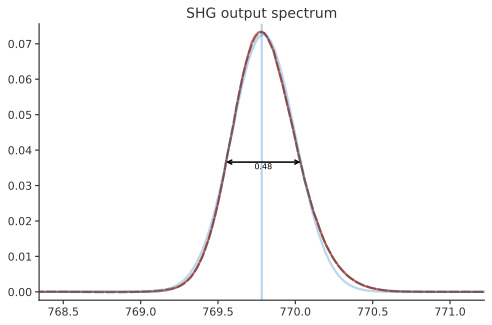

In [2]:


name_path = "..//data//shg_8_nm_filter//full power//WaveData20220726_012.csv"
wavelengths, values = load_spectrum_file(name_path)

fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(wavelengths, values, color=Colors['red'])

spline = SplineTool(np.array(values), np.array(wavelengths))
ax.plot(*spline.plot_spline(wavelengths,.001), color='k', ls='--', alpha=0.3)
spline.plot_width_at_level_arrows(ax, 0.5)
root = spline.full_width_at_level(0.5, .0001)

ax.set_xlim(spline.spline_max().x - 3*root.width, spline.spline_max().x + 3*root.width)
# print(root.right-root.left)
ax.set_title("SHG output spectrum")
ax.axvline(spline.spline_max().x, alpha=0.3)
ax.plot(*spline.plot_gaussian_fit(), alpha=0.3, label="gaussian fit")
print("SHG wavelength: ", spline.spline_max().x)
print("SHG bandwidth sigma: ", spline.sigma())


The data used for fitting to the JSI function is the DWDM grid data from figure 2 of the paper. This is arranged in an 8x8 grid, whereby the coincidence rate of channels near the main diagonal are measured.

In [3]:
with open("simplified_jsi_data_x8.json") as file:
    data = json.load(file)



for i in range(len(data["coinc_set"])):
    for j in range(len(data["coinc_set"][0])):
        data["coinc_set"][i][j] = round(data["coinc_set"][i][j], 1)

data["wl_B"].reverse()

# make sure all data has correct orientation

if len(data["coinc_set"]) == 16:
    st = "\t        "
else:
    st = "\t "
for item in data["wl_B"]:
    if len(data["coinc_set"]) == 16:
        st = st + " " + str(item[:-3])
    if len(data["coinc_set"]) == 8:
        st = st + " " + str(item)
print(st)
np.array(data["coinc_set"])
for i, row in enumerate(data["coinc_set"]):
    st = str(data["wl_A"][i])
    for item in row:
        st = st + "\t   " + str(item)
    print(st)

# wl_B is along the top, 52 to 59
# wl_A is along the side, 35 to 42


	  1530.33 1531.12 1531.9 1532.68 1533.47 1534.25 1535.04 1535.82
1549.32	   68.5	   32.9	   4.3	   0.0	   0.0	   0.0	   0.0	   0.0
1548.51	   25.7	   65.6	   38.0	   5.4	   0.0	   0.0	   0.0	   0.0
1547.72	   2.7	   25.4	   62.9	   32.3	   4.7	   0.0	   0.0	   0.0
1546.92	   0.0	   2.6	   27.6	   69.5	   40.2	   6.9	   0.0	   0.0
1546.12	   0.0	   0.0	   2.5	   25.6	   63.7	   36.3	   4.0	   0.0
1545.32	   0.0	   0.0	   0.0	   2.8	   29.0	   82.4	   37.6	   5.2
1544.53	   0.0	   0.0	   0.0	   0.0	   2.2	   23.9	   61.0	   30.5
1543.73	   0.0	   0.0	   0.0	   0.0	   0.0	   2.7	   27.1	   72.9


In [4]:
# 'flatten' the data to 1d arrays for eventual use in scipy.curve_fit

flat_coinc = []
flat_wl_A = []
flat_wl_B = []

for i, row in enumerate(data["coinc_set"]):
    for j, column in enumerate(row):
        flat_coinc.append(column)
        flat_wl_B.append(data["wl_B"][j])
        flat_wl_A.append(data["wl_A"][i])

flat_coinc = np.array(flat_coinc)
flat_wl_A = np.array(flat_wl_A)
flat_wl_B = np.array(flat_wl_B)

zeros_mask = (flat_coinc!=0)
flat_coinc = flat_coinc[zeros_mask]
flat_wl_A = flat_wl_A[zeros_mask]
flat_wl_B = flat_wl_B[zeros_mask]


# signal <--> B--> Y <--> x ????
# idler <--> A <--> X <--> y


idler = flat_wl_A # long to short
signal = flat_wl_B # short to long

data3d = np.array(list(zip(idler,signal,flat_coinc)))

In [5]:

print(Linb03_calculate_indexes(1540, 10)) #, ExtraordinaryIndex(), OrdinaryIndex()))
print(Mgo_doped_Linb03_calculate_indexes(1540, 10, ExtraordinaryIndex(), OrdinaryIndex()))


2.2115694228379756
2.1270978468543214


775nm n:  2.1655870663979355
1540nm n:  2.1263986575132896


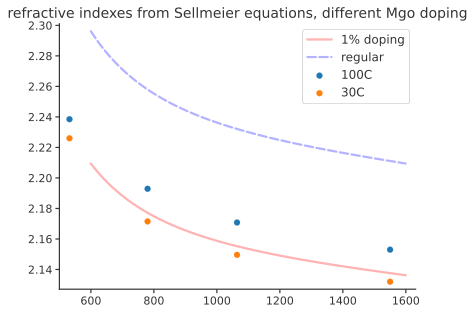

In [6]:
wavelengths = np.arange(600.0, 1600, 1.0).astype("float")
plt.figure()
plt.plot(
    wavelengths,
    Mgo_doped_Linb03_calculate_indexes(
        wavelengths, 50, ExtraordinaryIndex(), OrdinaryIndex()
    ),
    color="red",
    alpha=0.3,
    label="1% doping",
)
plt.plot(
    wavelengths,
    refractive_index_ppln(wavelengths),
    color="blue",
    alpha=0.3,
    ls="--",
    label="regular",
)

# these are some 'example' values from the covesion website.
plt.scatter([532, 780, 1064, 1550], [2.2385, 2.1929, 2.1708, 2.1530], label="100C")
plt.scatter([532, 780, 1064, 1550], [2.2260, 2.1715, 2.1496, 2.1320], label="30C")
plt.legend()
_ = plt.title("refractive indexes from Sellmeier equations, different Mgo doping")
print(
    "775nm n: ",
    Mgo_doped_Linb03_calculate_indexes(
        wavelengths[175], 20, ExtraordinaryIndex1Percent(), OrdinaryIndex()
    ),
)
print(
    "1540nm n: ",
    Mgo_doped_Linb03_calculate_indexes(
        wavelengths[940], 20, ExtraordinaryIndex1Percent(), OrdinaryIndex()
    ),
)


In [7]:
from dataclasses import asdict

params = JointSpectrumParams(
    detector=DetectorParams(sigma=53, w_0=1550),
    spdc=SpdcParams(
        w_central=spline.spline_max().x * 2,
        sigma_p=2*np.pi* frequency_and_bandwidth(spline.spline_max().x, spline.sigma()).sigma * 1e9,
        temp=50,
        L=1e7,
        gamma=1 / 18300,  # 18.3 um polling period
        sellmeier_ordinary = OrdinaryIndex(),
        sellmeier_extraordinary = ExtraordinaryIndex()
    ),
    A = 5e7
)

# asdict(params)


In [8]:
frequency_and_bandwidth(spline.spline_max().x, spline.sigma())

FreqBandwidth(freq=389.450762993622, freq_unit='THz', sigma=103.0408107664375, sigma_unit='GHz')

40.0

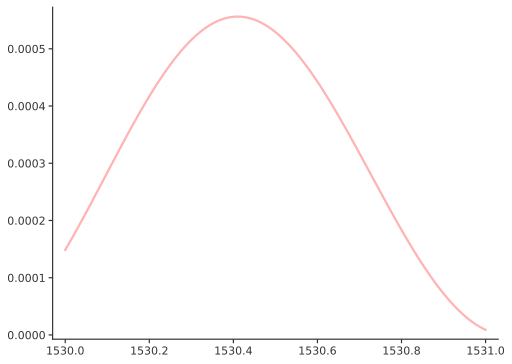

In [9]:
num_points = 1000

w_idler = np.linspace(1530, 1531, num_points)
w_signal = np.linspace(1530, 1531, num_points)
# w_0 = 1539
# gamma = 0.0000526448
# temp = 50
# length = 1e7
# this = phase_mismatch(w_idler, w_signal, 1550, params.spdc.gamma, params.spdc.temp)

ranges = np.linspace(-30, 30, 2000)
# gauss_amp = gaussian(ranges, 1, 0, 1)/np.sum(gaussian(ranges, 1, 0, 1))
# for i, range in enumerate(ranges):
#     if i == 0:
#         this = gauss_amp[i]*sinc2_monochromatic(w_idler, w_signal, w_0+range, gamma, params.spdc)
#     this += gauss_amp[i]*sinc2_monochromatic(w_idler, w_signal, w_0+range, gamma, params.spdc)

# this = this/len(ranges)

#this = sinc2_monochromatic(w_idler, w_signal, w_0, gamma, 1e7) + sinc2_monochromatic(w_idler, w_signal, w_0-10, gamma, 1e7) + sinc2_monochromatic(w_idler, w_signal, w_0+10, gamma, 1e7) + sinc2_monochromatic(w_idler, w_signal, w_0+20, gamma, 1e7) + sinc2_monochromatic(w_idler, w_signal, w_0+30, gamma, 1e7) + sinc2_monochromatic(w_idler, w_signal, w_0+40, gamma, 1e7)
this_red = sinc2_monochromatic(w_idler, w_signal, params.spdc.gamma, params.spdc)
fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.plot(w_idler,this_red, color= 'red', alpha=0.3)
# plt.plot(w_idler, this)

# plt.yscale('log')



.0008*1e5/2

In [10]:
print("")
print("refractive index @ 1540 nm: ",refractive_index_ppln(1540))
print("refractive index @ 770 nm: ",refractive_index_ppln(770))
print("")

print("choose that idler goes from short wavelength (like 1517) to up to 1540")
print("choose that signal goes from 1540 to longer wavelegnth")




refractive index @ 1540 nm:  2.21145099670458
refractive index @ 770 nm:  2.259374268658871

choose that idler goes from short wavelength (like 1517) to up to 1540
choose that signal goes from 1540 to longer wavelegnth


In [11]:
gamma_guess = 3e-4  # 3.9e-4
A_guess = 3e7  # 7481585.54714451
p_guess = [gamma_guess, A_guess]  # ,sigma_p_guess]
# if we want to float L, should fix sigma_p, because both have effects on width (can't optimize)

# you can use optimize.curve_fit to fit 2D data. See here:
#  https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/

popt, pcov = curve_fit(
    wrapper_joint_spectrum(params), data3d[:, :2], data3d[:, 2], p0=p_guess #inputs x and y, outputs, and p0
)


In [12]:

signal_wl, idler_wl, X, Y = create_signal_idler_arrays(data["wl_A"], data["wl_B"])



prinfo(data["wl_A"])
prinfo(data["wl_B"])
prinfo(signal_wl[-1] - signal_wl[0])
prinfo(idler_wl[-1] - idler_wl[0])
prinfo(np.sum(np.diff(data["wl_A"])))
prinfo(np.sum(np.diff(data["wl_B"])))
prinfo(np.sum(np.diff(signal_wl)))

data["wl_A"] = [1549.32, 1548.51, 1547.72, 1546.92, 1546.12, 1545.32, 1544.53, 1543.73]
data["wl_B"] = [1530.33, 1531.12, 1531.9, 1532.68, 1533.47, 1534.25, 1535.04, 1535.82]
signal_wl[-1] - signal_wl[0] = 7.187142857142817
idler_wl[-1] - idler_wl[0] = 7.087142857142908
np.sum(np.diff(data["wl_A"])) = -5.589999999999918
np.sum(np.diff(data["wl_B"])) = 5.490000000000009
np.sum(np.diff(signal_wl)) = 7.187142857142817


Text(-0.01, 1.11, 'a)')

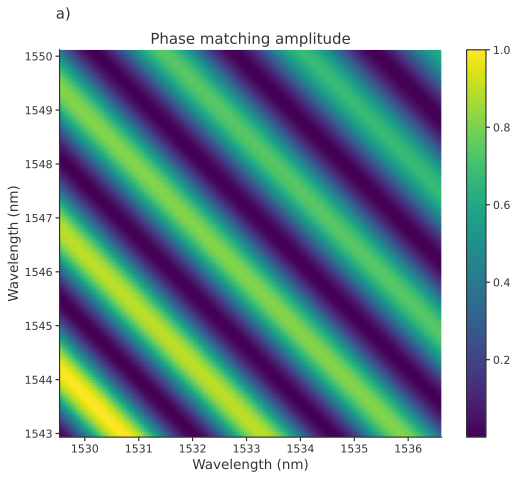

In [13]:
# X, Y = np.meshgrid(idler_wl, signal_wl)
detector_mat = detector_profile(X, Y, params.detector)
sinc2_mat = sinc2_monochromatic(X, Y, params.spdc.gamma, params.spdc)
################################ Plot

fontsize = 10*1.5
fontsize_x = 9*1.5
fontsize_y = 9*1.5
labelsize = 8*1.5
ticks = np.arange(0, 1.25, 0.25)
# Plotting modes

fig, ax = plt.subplots(1,1,figsize=(9,7))
ax_text_loc = (-0.01, 1.11)

z = sinc2_mat / np.max(sinc2_mat)
z = z[:-1, :-1]


img = ax.imshow(z,
           extent=[X.min(), X.max(), Y.min(), Y.max()],
           interpolation='nearest', origin='lower') # for faster
cbar = fig.colorbar(img, ax=ax)


ax.set_xlabel("Wavelength (nm)", fontsize=fontsize_x)
ax.set_ylabel("Wavelength (nm)", fontsize=fontsize_y)
ax.set_title("Phase matching amplitude", fontsize=fontsize)
ax.annotate(
    "a)",
    xy=ax_text_loc,
    xycoords="axes fraction",
    horizontalalignment="left",
    verticalalignment="top",
    fontsize=fontsize,
)




In [14]:

# params.spdc.L = 7e6
# params.spdc.gamma = 1/18500
# params.spdc.temp  = 36
# params.spdc.sellmeier_extraordinary = ExtraordinaryIndex1Percent()
# params.spdc.w_central = 1540.1

detector_mat = detector_profile(X, Y, params.detector)
joint = joint_spectrum(X, Y, params.spdc.gamma, 50000000, params)

fontsize = 10*1.5
fontsize_x = 9*1.5
fontsize_y = 9*1.5
labelsize = 8*1.5
ticks = np.arange(0, 1.25, 0.25)
# Plotting modes

fig, ax = plt.subplots(1,1,figsize=(8,7))
ax_text_loc = (-0.01, 1.11)

z = joint
z = z[:-1, :-1]

cp = ax.pcolorfast(X, Y, z) # to make sure the axese are correct
cp = ax.imshow(z,
           extent=[X.min(), X.max(), Y.min(), Y.max()],
           vmin=z.min(), vmax=z.max(),
          #  vmin=0, vmax=1,
           interpolation='nearest', origin='lower') # for faster

norm = Normalize(vmin=0, vmax=1) # normalization based on the raw data

ax.set_xlabel("Wavelength (nm)", fontsize=fontsize_x)
ax.set_ylabel("Wavelength (nm)", fontsize=fontsize_y)
ax.set_title("Phase matching amplitude", fontsize=fontsize)
cbar = fig.colorbar(cp, ax=ax)
cbar.ax.tick_params(labelsize=labelsize)
cbar.set_ticks(ticks)
ax.annotate(
    "a)",
    xy=ax_text_loc,
    xycoords="axes fraction",
    horizontalalignment="left",
    verticalalignment="top",
    fontsize=fontsize,
)
sc = ax.scatter(
    flat_wl_B,
    flat_wl_A,
    marker="s",
    facecolors="None",
    c=flat_coinc/(0.86*np.max(flat_coinc)),
    cmap="viridis",
    norm=norm,
    s=390,
    alpha=1,
    edgecolors='darkgrey',
    linewidth = 1
)



In [15]:
# lmfit_wrapper_join_spectrum


mod = Model(lmfit_wrapper_join_spectrum)
params.spdc.L = 10e6

lmfit_params = mod.make_params(detector_sigma=dict(value=params.detector.sigma, vary=False),
                               detector_w_0=dict(value=params.detector.w_0, vary=False),
                               spdc_w_central=dict(value=params.spdc.w_central, vary=True, min=1539.2, max=1539.9),
                               spdc_sigma_p=dict(value=params.spdc.sigma_p, vary=False, min=347424508247, max=1547424508247),
                               spdc_temp=dict(value=params.spdc.temp, vary=True, min=0, max=100),
                               spdc_L=dict(value=params.spdc.L, vary=True, min=1e3, max=1e8),
                               spdc_gamma=dict(value=params.spdc.gamma, vary=True, min=1/18500, max=1/18100),
                               A=dict(value=5e9, vary=True, min=2e7, max=2e11))

# mod.param_names

independent_data = data3d[:, :2]
dependent_data = data3d[:, 2]

result=mod.fit(dependent_data, lmfit_params, M=independent_data, method="powell")
# mod.independent_vars
result


In [16]:
detector_params = DetectorParams(sigma=result.best_values["detector_sigma"], w_0=result.best_values["detector_w_0"])
spdc_params = SpdcParams(
        w_central=result.best_values["spdc_w_central"],
        sigma_p=result.best_values["spdc_sigma_p"],
        temp=result.best_values["spdc_temp"],
        L=result.best_values["spdc_L"],
        gamma=result.best_values["spdc_gamma"],
        sellmeier_ordinary=OrdinaryIndex(),
        sellmeier_extraordinary=ExtraordinaryIndex1Percent(),
    )
fit_params = JointSpectrumParams(detector_params, spdc_params, A=result.best_values["A"])

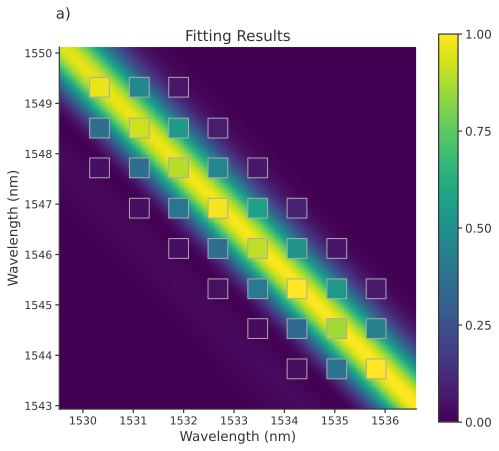

In [17]:
joint = joint_spectrum(X, Y, fit_params.spdc.gamma, fit_params.A, fit_params)
fontsize = 10*1.5
fontsize_x = 9*1.5
fontsize_y = 9*1.5
labelsize = 8*1.5
ticks = np.arange(0, 1.25, 0.25)
# Plotting modes
fig, ax = plt.subplots(1,1,figsize=(8,7))
ax_text_loc = (-0.01, 1.11)
z = joint
z = z[:-1, :-1]

norm = Normalize(vmin=0, vmax=1) # normalization based on the raw data


z_normalized_by_raw_data = z/(0.86*np.max(flat_coinc))

# cp = ax.pcolorfast(X, Y, z) # to make sure the axese are correct
cp = ax.imshow(z_normalized_by_raw_data,
           extent=[X.min(), X.max(), Y.min(), Y.max()],
           vmin=0, vmax=1,
           interpolation='nearest', origin='lower') # for faster

ax.set_xlabel("Wavelength (nm)", fontsize=fontsize_x)
ax.set_ylabel("Wavelength (nm)", fontsize=fontsize_y)
ax.set_title("Fitting Results", fontsize=fontsize)
cbar = fig.colorbar(cp, ax=ax)
cbar.ax.tick_params(labelsize=labelsize)
cbar.set_ticks(ticks)
ax.annotate(
    "a)",
    xy=ax_text_loc,
    xycoords="axes fraction",
    horizontalalignment="left",
    verticalalignment="top",
    fontsize=fontsize,
)

sc = ax.scatter(
    flat_wl_B,
    flat_wl_A,
    marker="s",
    facecolors="None",
    c=flat_coinc/(0.86*np.max(flat_coinc)),
    cmap="viridis",
    norm=norm,
    s=390,
    alpha=1,
    edgecolors='darkgrey',
    linewidth = 1
)


## Spread this out over the C band, and also the L and S bands.

### S beginning to end of L band goes from 1460 to 1620

### C band in the center goes from 1530 to 1565

Run the numbers for the 3 bands seperately. 

In [18]:
joint_spectrum(1530.33, 1549.32, fit_params.spdc.gamma, fit_params.A, fit_params)

68.34579483154135

In [19]:
X_flat = np.average(X, axis=0)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

find_nearest(X, 1530.33)
X_flat[find_nearest(X, 1530.33)]



1530.3400287631875

In [20]:
from bokeh.plotting import figure, show
import numpy as np
from bokeh.io import output_notebook
output_notebook(hide_banner=True)
   
dwdm_g = Dwdm(gaussian=True, width_adj=1)
dwdm = Dwdm()

wl = np.linspace(1520, 1590, 1000)
wl_fg = dwdm_g.from_array(wl, 1535)
wl_f = dwdm.from_array(wl, 1535)



# plt.plot(wl, wl_f)

colors, swatches = viz.bokeh_theme()

p = figure(width=800, height=400, output_backend="webgl")
p.line(x=wl, y=wl_fg, line_color=colors["blue"], line_width=2, line_alpha=1)
p.line(x=wl, y=wl_f, line_color=colors["red"], line_width=2, line_alpha=1)
show(p)




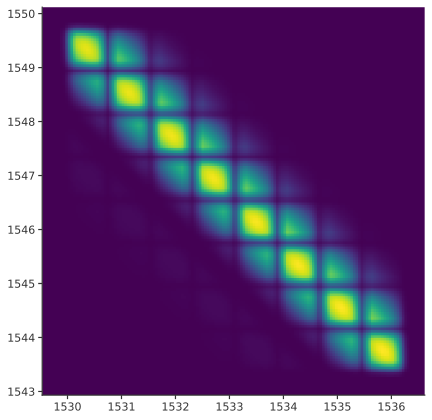

In [21]:
flat = np.ones((150,150))

fontsize = 10*1.5
fontsize_x = 9*1.5
fontsize_y = 9*1.5
labelsize = 8*1.5
ticks = np.arange(0, 1.25, 0.25)
# Plotting modes

fig, ax = plt.subplots(1,1,figsize=(8,7))
ax_text_loc = (-0.01, 1.11)


norm = Normalize(vmin=0, vmax=1) # normalization based on the raw data


# dwdm_2d = dwdm2D(X,Y, data["wl_B"][4], data["wl_A"][4])


dwdm_2d = np.zeros(np.shape(X))
for wl_B in data["wl_B"]:
    for wl_A in data["wl_A"]:
        dwdm_2d += dwdm2D(X,Y, wl_B, wl_A, width_adj=1) #, gaussian=True)


# signal --> B--> X
# idler --> A--> Y
joint = joint_spectrum(X, Y, fit_params.spdc.gamma, fit_params.A, fit_params)
z = joint*dwdm_2d

dwdm_joint = joint*dwdm_2d/(np.max(joint*dwdm_2d))


z = dwdm_joint[:-1, :-1]

# cp = ax.pcolorfast(X, Y, z) # to make sure the axese are correct
cp = ax.imshow(z,
           extent=[X.min(), X.max(), Y.min(), Y.max()],
           vmin=0, vmax=1,
           interpolation='nearest', origin='lower') # for faster

In [39]:
WIDTH = 0.5
signal_wl, idler_wl, X, Y = create_signal_idler_arrays(data["wl_A"], data["wl_B"], number_pts=800)
joint = joint_spectrum(X, Y, fit_params.spdc.gamma, fit_params.A, fit_params)
single_dwdm_2d = dwdm2D(X,Y, data["wl_B"][4], data["wl_A"][4], width_adj=WIDTH) #, gaussian=True)
dwdm_joint_single = joint*single_dwdm_2d

# z = z/(np.max(joint)*np.max(dwdm_2d))
dwdm_joint_single = dwdm_joint_single/(np.max(dwdm_joint_single))


u_dwdm, s_dwdm, vh_dwdm = np.linalg.svd(dwdm_joint_single)#/np.sum(signal1_idler_twofold))
svd_dwdm = s_dwdm/np.sum(s_dwdm)
ssum = np.sum(svd_dwdm**2)
K= 1/ssum
prinfo(K)
inverse_K = 1/K
prinfo(inverse_K)

K = 1.0449947522735628
inverse_K = 0.9569426045674688


Text(0.5, 1.0, 'Schmidt Decomposition Coefficients')

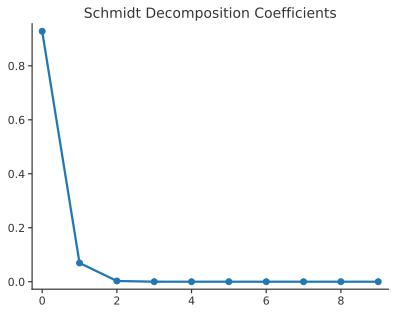

In [23]:
plt.plot(svd_dwdm[:10], '-o')
plt.title("Schmidt Decomposition Coefficients")

## filter intergrate fit:

In [24]:
# signal_wl, idler_wl, X, Y = create_signal_idler_arrays(data["wl_A"], data["wl_B"], number_pts=100)

# %timeit lmfit_wrapper_join_spectrum_filter_integrate(independent_data,X,Y,params.detector.sigma, params.detector.w_0, params.spdc.w_central, params.spdc.sigma_p, params.spdc.temp, params.spdc.L, params.spdc.gamma, params.A)

In [25]:
params.spdc.w_central

1539.5653904774076

In [26]:
# this takes several seconds. Internally, this is using a 80x80 point grid for integration. 

mod = Model(lmfit_wrapper_join_spectrum_filter_integrate)
params.spdc.L = 10e6

lmfit_params_fi = mod.make_params(
                               detector_sigma=dict(value=params.detector.sigma, vary=False),
                               detector_w_0=dict(value=params.detector.w_0, vary=False),
                               spdc_w_central=dict(value=params.spdc.w_central, vary=False, min=1539.2, max=1542),
                               spdc_sigma_p=dict(value=params.spdc.sigma_p, vary=False),
                               spdc_temp=dict(value=params.spdc.temp, vary=True, min=0, max=100),
                               spdc_L=dict(value=params.spdc.L, vary=True, min=1e3, max=1e8),
                               spdc_gamma=dict(value=params.spdc.gamma, vary=False, min=1/18500, max=1/18100),
                               A=dict(value=5e9, vary=True, min=2e7, max=2e11))

independent_data = data3d[:, :2]
dependent_data = data3d[:, 2]

result=mod.fit(dependent_data, lmfit_params_fi, M=independent_data, method="powell")
# mod.independent_vars
result

In [38]:
frequency_and_bandwidth(769.782695, 0.48)

FreqBandwidth(freq=389.45076311438777, freq_unit='THz', sigma=242.843059060875, sigma_unit='GHz')

In [28]:
detector_params = DetectorParams(sigma=result.best_values["detector_sigma"], w_0=result.best_values["detector_w_0"])
spdc_params = SpdcParams(
        w_central=result.best_values["spdc_w_central"],
        sigma_p=result.best_values["spdc_sigma_p"],
        temp=result.best_values["spdc_temp"],
        L=result.best_values["spdc_L"],
        gamma=result.best_values["spdc_gamma"],
        sellmeier_ordinary=OrdinaryIndex(),
        sellmeier_extraordinary=ExtraordinaryIndex1Percent(),
    )
fit_params = JointSpectrumParams(detector_params, spdc_params, A=result.best_values["A"])

In [29]:
fit_params.A

6139197427.241346

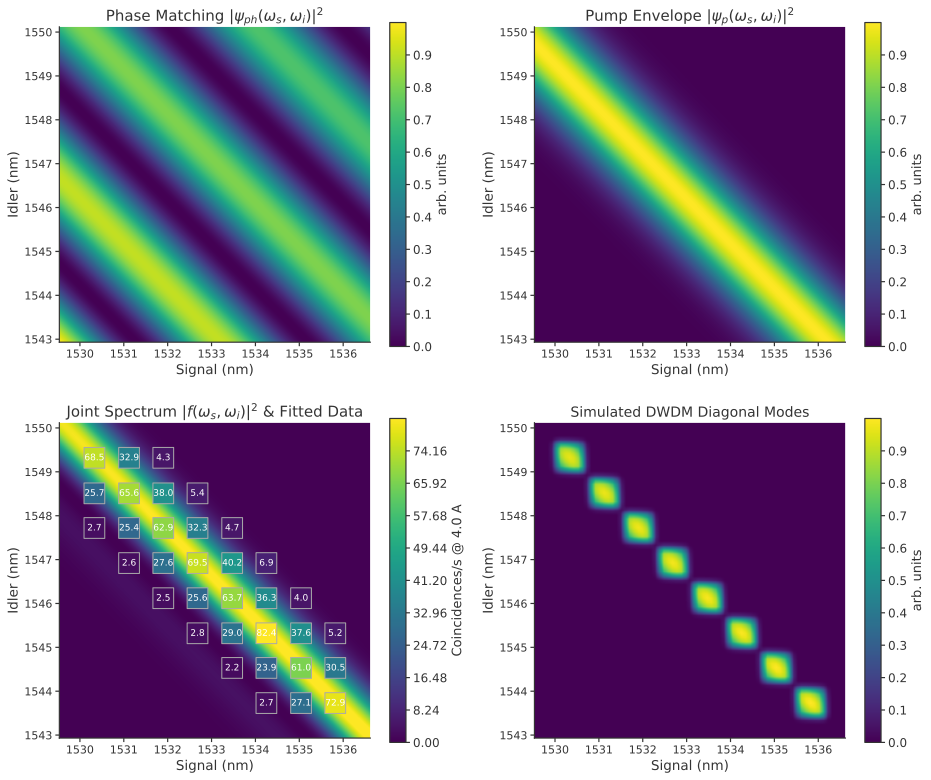

In [30]:
fontsize = 10*1.5
fontsize_x = 9*1.5
fontsize_y = 9*1.5
labelsize = 8*1.5



fig = plt.figure(figsize=(12, 10))
divider_width = 0.1
master_left, master_right = bisect(
            [0, 0, 1, 1],
            offset=0.5,
            spacing=divider_width,
            absolute_spacing=True,
        )
bottom_left, top_left = bisect(
            master_left,
            offset=0.5,
            direction="horiz",
            spacing=divider_width,
            absolute_spacing=True,
        )
bottom_right, top_right= bisect(
            master_right,
            offset=0.5,
            direction="horiz",
            spacing=divider_width,
            absolute_spacing=True,
        )
ax_top_left = fig.add_axes(top_left)
ax_bottom_left = fig.add_axes(bottom_left)
ax_top_right = fig.add_axes(top_right)
ax_bottom_right= fig.add_axes(bottom_right)



ax_text_loc = (-0.01, 1.11)


def plot_joint_spectrum(ax):
    scaling = np.max(flat_coinc)
    ticks = np.arange(0, scaling, round(scaling/10,2))


    joint = joint_spectrum(X, Y, fit_params.spdc.gamma, fit_params.A, fit_params)
    z = joint
    z = z[:-1, :-1]

    norm = Normalize(vmin=0, vmax=scaling) # normalization based on the raw data


    z_normalized_by_raw_data = z/(0.92*np.max(flat_coinc))

    # cp = ax.pcolorfast(X, Y, z) # to make sure the axese are correct
    cp = ax.imshow(scaling*z_normalized_by_raw_data,
            extent=[X.min(), X.max(), Y.min(), Y.max()],
            vmin=0, vmax=scaling,
            interpolation='nearest', origin='lower') # for faster

    ax.set_xlabel("Signal (nm)", fontsize=fontsize_x)
    ax.set_ylabel("Idler (nm)", fontsize=fontsize_y)
    ax.set_title(r"Joint Spectrum $|f(\omega_s, \omega_i)|^2$ & Fitted Data", fontsize=fontsize)
    cbar = fig.colorbar(cp, ax=ax)
    cbar.ax.tick_params(labelsize=labelsize)
    cbar.set_ticks(ticks)
    cbar.set_label("Coincidences/s @ 4.0 A")


    sc = ax.scatter(
        flat_wl_B,
        flat_wl_A,
        marker="s",
        facecolors="None",
        c=scaling*flat_coinc/(0.92*np.max(flat_coinc)),
        cmap="viridis",
        norm=norm,
        s=430,
        alpha=1,
        edgecolors='darkgrey',
        linewidth = 1
    )

    for i in range(len(data["coinc_set"])):
        for j in range(len(data["coinc_set"])):
            if data["coinc_set"][i][j] == 0:
                # label = '∅'
                label = ''
            else:
                label = data["coinc_set"][i][j]
            text = ax.text(data["wl_B"][j], data["wl_A"][i], label, size=9,
                        ha="center", va="center", 
                        color="white", alpha=1)

def plot_phase_matching_condition(ax):
    scaling = 1
    ticks = np.arange(0, scaling, round(scaling/10,2))
    c = 3 * 10**8 * 10**9  # nm/s
    phase_matching = sinc2_monochromatic(X, Y, fit_params.spdc.gamma, fit_params.spdc) # *pump_envelope(2*np.pi*c/X, 2*np.pi*c/Y, 2*np.pi*c/fit_params.spdc.w_central, fit_params.spdc.sigma_p)
    z = phase_matching
    z = z[:-1, :-1]/np.max(z)

    cp = ax.imshow(scaling*z,
            extent=[X.min(), X.max(), Y.min(), Y.max()],
            vmin=0, vmax=scaling,
            interpolation='nearest', origin='lower') # for faster

    ax.set_xlabel("Signal (nm)", fontsize=fontsize_x)
    ax.set_ylabel("Idler (nm)", fontsize=fontsize_y)
    ax.set_title(r"Phase Matching $|\psi_{ph}\left(\omega_s, \omega_i\right)|^2$", fontsize=fontsize)
    cbar = fig.colorbar(cp, ax=ax)
    cbar.ax.tick_params(labelsize=labelsize)
    cbar.set_ticks(ticks)
    cbar.set_label("arb. units")

def plot_pump_envelope(ax):
    scaling = 1
    ticks = np.arange(0, scaling, round(scaling/10,2))
    c = 3 * 10**8 * 10**9  # nm/s
    pump = pump_envelope(2*np.pi*c/X, 2*np.pi*c/Y, 2*np.pi*c/fit_params.spdc.w_central, fit_params.spdc.sigma_p)
    z = pump
    z = z[:-1, :-1]/np.max(z)
    cp = ax.imshow(scaling*z,
            extent=[X.min(), X.max(), Y.min(), Y.max()],
            vmin=0, vmax=scaling,
            interpolation='nearest', origin='lower') # for faster

    ax.set_xlabel("Signal (nm)", fontsize=fontsize_x)
    ax.set_ylabel("Idler (nm)", fontsize=fontsize_y)
    ax.set_title(r"Pump Envelope $|\psi_p\left(\omega_s, \omega_i\right)|^2$", fontsize=fontsize)
    cbar = fig.colorbar(cp, ax=ax)
    cbar.ax.tick_params(labelsize=labelsize)
    cbar.set_ticks(ticks)
    cbar.set_label("arb. units")

def plot_simulated_pump_transmission(ax):
    scaling = 1
    ticks = np.arange(0, scaling, round(scaling/10,2))
    dwdm_2d = np.zeros(np.shape(X))
    for i, wl_B in enumerate(data["wl_B"]):
        for j, wl_A in enumerate(data["wl_A"]):
            if i==j:
                dwdm_2d += dwdm2D(X,Y, wl_B, wl_A, width_adj=1, gaussian=False)
    joint = joint_spectrum(X, Y, fit_params.spdc.gamma, fit_params.A, fit_params)


    # z = z/(np.max(joint)*np.max(dwdm_2d))
    dwdm_joint = joint*dwdm_2d/(np.max(joint*dwdm_2d))


    z = dwdm_joint[:-1, :-1]

    # cp = ax.pcolorfast(X, Y, z) # to make sure the axese are correct
    cp = ax.imshow(z,
            extent=[X.min(), X.max(), Y.min(), Y.max()],
            vmin=0, vmax=1,
            interpolation='nearest', origin='lower') # for faster
    ax.set_title("Simulated DWDM Diagonal Modes")
    ax.set_xlabel("Signal (nm)", fontsize=fontsize_x)
    ax.set_ylabel("Idler (nm)", fontsize=fontsize_y)
    cbar = fig.colorbar(cp, ax=ax)
    cbar.ax.tick_params(labelsize=labelsize)
    cbar.set_ticks(ticks)
    cbar.set_label("arb. units")

plot_phase_matching_condition(ax_top_left)
plot_pump_envelope(ax_top_right)
plot_joint_spectrum(ax_bottom_left)
plot_simulated_pump_transmission(ax_bottom_right)

plt.savefig("JSI_sim_results.pdf")

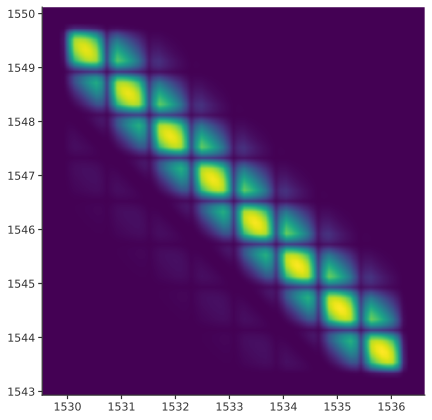

In [31]:

signal_wl, idler_wl, X, Y = create_signal_idler_arrays(data["wl_A"], data["wl_B"], number_pts=500)

flat = np.ones((150,150))

fontsize = 10*1.5
fontsize_x = 9*1.5
fontsize_y = 9*1.5
labelsize = 8*1.5
ticks = np.arange(0, 1.25, 0.25)
# Plotting modes

fig, ax = plt.subplots(1,1,figsize=(8,7))
ax_text_loc = (-0.01, 1.11)


norm = Normalize(vmin=0, vmax=1) # normalization based on the raw data


# dwdm_2d = dwdm2D(X,Y, data["wl_B"][4], data["wl_A"][4])


dwdm_2d = np.zeros(np.shape(X))
for wl_B in data["wl_B"]:
    for wl_A in data["wl_A"]:
        dwdm_2d += dwdm2D(X,Y, wl_B, wl_A, width_adj=1, gaussian=False)

# dwdm_2d_2 = dwdm2D(X,Y, data["wl_B"][1], data["wl_A"][0])X

# signal --> B--> X
# idler --> A--> Y
joint = joint_spectrum(X, Y, fit_params.spdc.gamma, fit_params.A, fit_params)
z = joint*dwdm_2d

# z = z/(np.max(joint)*np.max(dwdm_2d))
dwdm_joint = joint*dwdm_2d/(np.max(joint*dwdm_2d))


z = dwdm_joint[:-1, :-1]

# cp = ax.pcolorfast(X, Y, z) # to make sure the axese are correct
cp = ax.imshow(z,
           extent=[X.min(), X.max(), Y.min(), Y.max()],
           vmin=0, vmax=1,
           interpolation='nearest', origin='lower') # for faster

In [32]:
WIDTH = 1
GAUSSIAN = False

joint = joint_spectrum(X, Y, fit_params.spdc.gamma, fit_params.A, fit_params)
single_dwdm_2d = dwdm2D(X,Y, data["wl_B"][4], data["wl_A"][4], width_adj=WIDTH, gaussian=GAUSSIAN)
dwdm_joint_single = joint*single_dwdm_2d

# z = z/(np.max(joint)*np.max(dwdm_2d))
dwdm_joint_single = dwdm_joint_single/(np.max(dwdm_joint_single))


u_dwdm, s_dwdm, vh_dwdm = np.linalg.svd(dwdm_joint_single)#/np.sum(signal1_idler_twofold))
svd_dwdm = s_dwdm/np.sum(s_dwdm)
ssum = np.sum(svd_dwdm**2)
K= 1/ssum
prinfo(K)
inverse_K = 1/K
prinfo(inverse_K)

K = 1.1745947100368106
inverse_K = 0.8513574865058442


In [33]:
idler

array([1549.32, 1549.32, 1549.32, 1548.51, 1548.51, 1548.51, 1548.51,
       1547.72, 1547.72, 1547.72, 1547.72, 1547.72, 1546.92, 1546.92,
       1546.92, 1546.92, 1546.92, 1546.12, 1546.12, 1546.12, 1546.12,
       1546.12, 1545.32, 1545.32, 1545.32, 1545.32, 1545.32, 1544.53,
       1544.53, 1544.53, 1544.53, 1543.73, 1543.73, 1543.73])

In [34]:


with open('LCS_bands.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    wavelengths = []
    channels = []
    band = []
    for row in csv_reader:
        wavelengths.append(float(row[0]))
        channels.append(int(row[1]))
        band.append(row[2])

wavelengths = np.array(wavelengths)
channels = np.array(channels)

idler_full = wavelengths[wavelengths>1542.94]
signal_full = np.flip(wavelengths[wavelengths<1536.61]) # to match data["wl_B"] and data["wl_A"]

idler_full = idler_full[21:]
# print(data["wl_A"])
# print(idler_full)


In [35]:
signal_wl, idler_wl, X, Y = create_signal_idler_arrays(idler_full, signal_full, number_pts=2000)
# signal_wl, idler_wl, X, Y = create_signal_idler_arrays([1650, 1543.73], [1429.55, 1535.82], number_pts=2000, df=0.8)

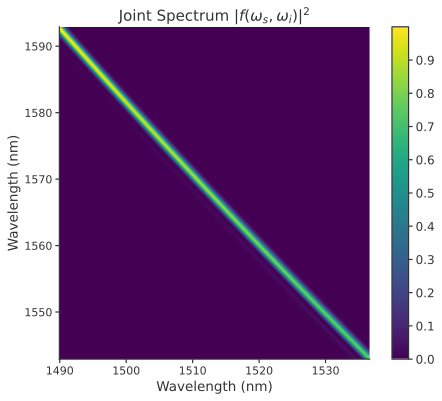

In [36]:
joint = joint_spectrum_no_detector(X, Y, fit_params.spdc.gamma, fit_params.A, fit_params)
z = joint
z = z[:-1, :-1]/np.max(joint)
scaling = 1
ticks = np.arange(0,1,0.1)

norm = Normalize(vmin=0, vmax=scaling) # normalization based on the raw data

fig, ax = plt.subplots(1,1,figsize=(8,6))
z_normalized_by_raw_data = z

# def create_wide_view_joint_spectrum(ax):
cp = ax.imshow(scaling*z_normalized_by_raw_data,
        extent=[X.min(), X.max(), Y.min(), Y.max()],
        vmin=0, vmax=scaling,
        interpolation='nearest', origin='lower') # for faster

ax.set_xlabel("Wavelength (nm)", fontsize=fontsize_x)
ax.set_ylabel("Wavelength (nm)", fontsize=fontsize_y)
ax.set_title(r"Joint Spectrum $|f(\omega_s, \omega_i)|^2$", fontsize=fontsize)
cbar = fig.colorbar(cp, ax=ax)
cbar.ax.tick_params(labelsize=labelsize)
cbar.set_ticks(ticks)

Text(0.5, 1.0, 'Simulated DWDM Diagonal Modes')

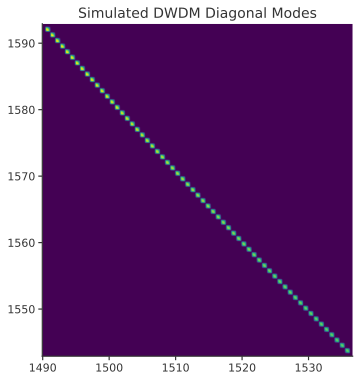

In [37]:
dwdm_2d = np.zeros(np.shape(X))
for i, wl_B in enumerate(signal_full):
    for j, wl_A in enumerate(idler_full):
        if i==j:
            dwdm_2d += dwdm2D(X,Y, wl_B, wl_A, width_adj=1, gaussian=False)
joint = joint_spectrum_no_detector(X, Y, fit_params.spdc.gamma, fit_params.A, fit_params)


# z = z/(np.max(joint)*np.max(dwdm_2d))
# dwdm_joint = joint/np.max(joint)
dwdm_joint = joint*dwdm_2d/(np.max(joint*dwdm_2d))


z = dwdm_joint[:-1, :-1]

fig, ax = plt.subplots(1,1,figsize=(6,6))
# cp = ax.pcolorfast(X, Y, z) # to make sure the axese are correct
cp = ax.imshow(z,
        extent=[X.min(), X.max(), Y.min(), Y.max()],
        vmin=0, vmax=1,
        interpolation='nearest', origin='lower') # for faster
ax.set_title("Simulated DWDM Diagonal Modes")